In [1]:
import os
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import pandas as pd
import numpy as np

data_dir = os.path.join(os.getcwd(),'data')


In [41]:
land = xr.open_dataset(os.path.join(data_dir,'MCD12C1.A2022001.061.2023244164746.hdf'), engine="netcdf4")
#land

In [42]:

land_first_df = land['Land_Cover_Type_1_Percent'].to_dataframe()
classes_count = 17

In [43]:
 land_df = land_first_df.copy()

In [44]:

# For testing just take head() of a multiple of classes_count
#land_df = land_df.query('Num_IGBP_Classes:MOD12C1 != 0')
#land_df = land_df.head(10000000*classes_count)
land_df
areas_count = len(land_df)/classes_count
print(f'There are {areas_count} initial areas in this dataset')

There are 25920000.0 initial areas in this dataset


In [45]:

# # Reset the index and drop the unnecessary index levels
# Takes about 6 minutes on local machine for whole dataset
land_df.reset_index(level=['YDim:MOD12C1', 'XDim:MOD12C1', 'Num_IGBP_Classes:MOD12C1'], inplace=True)

# Rename the 'Land_Cover_Type_1_Percent' column
land_df.rename(columns={'Land_Cover_Type_1_Percent': 'Percentage', 'Num_IGBP_Classes:MOD12C1':'MODIS Number'}, inplace=True)


# Two additional exclusions are made to the total amount of land; 
# land which has been designated as protected in the ‘World Database on Protected Areas’33 
# and land which is steeply sloping (i.e. >15 degrees)

In [46]:
# Convert the 'Percentage' column to numeric values
land_df['Percentage'] = land_df['Percentage'].astype(float) / 100.0

# Calculate latitude and longitude from grid indices
grid_size = 0.05  # 0.05 degrees
land_df['Latitude'] = 90.0 - grid_size * land_df['YDim:MOD12C1']
land_df['Longitude'] = -180.0 + grid_size * land_df['XDim:MOD12C1']


In [47]:

# Round latitude and longitude to the nearest 1-degree intervals
land_df['rounded_lat'] = (land_df['Latitude'] // 1) * 1
land_df['rounded_lon'] = (land_df['Longitude'] // 1) * 1

# Group by the rounded latitude, longitude, and class, and calculate the mean Percentage
land_df = land_df.groupby(['rounded_lat', 'rounded_lon', 'MODIS Number'])['Percentage'].mean().reset_index()

# Rename the 'Percentage' column
land_df.rename(columns={'Percentage': 'class_fraction'}, inplace=True)


In [48]:
land_df

rounded_lat  rounded_lon  MODIS Number  class_fraction
0              -90.0       -180.0             0        0.665658
1              -90.0       -180.0             1        0.000000
2              -90.0       -180.0             2        0.000000
3              -90.0       -180.0             3        0.000000
4              -90.0       -180.0             4        0.000000
...              ...          ...           ...             ...
1107715         90.0        179.0            12        0.000000
1107716         90.0        179.0            13        0.000000
1107717         90.0        179.0            14        0.000000
1107718         90.0        179.0            15        0.000000
1107719         90.0        179.0            16        0.000000

[1107720 rows x 4 columns]

In [49]:
ref_power_availability = {
    'Land Cover Type': [
        'Water',
        'Evergreen Needleleaf Forests',
        'Evergreen Broadleaf Forests',
        'Deciduous Needleleaf Forests',
        'Deciduous Broadleaf Forests',
        'Mixed Forests',
        'Closed Shrublands',
        'Open Shrublands',
        'Woody Savannas',
        'Savannas',
        'Grasslands',
        'Permanent Wetlands',
        'Croplands',
        'Urban and Built-up Lands',
        'Cropland/Natural Vegetation Mosaic',
        'Permanent Snow and Ice',
        'Barren'
    ],
    'MODIS Number': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
    ],
    'Wind': [
        '-', '-', '-', '-', '-', '-', 0.5, 0.5, 0.2, 0.2, 0.2, '-', 0.05, '-', 0.05, '-', 1
    ],
    'Solar': [
         '-', '-', '-', '-', '-', '-', 0.5, 0.5, 0.2, 0.2, 0.2, '-', '-', 0.03, '-', '-', 1
    ]
}

# Replace '-' with 0 in Wind and Solar columns
ref_power_availability['Wind'] = [0 if x == '-' else float(x) for x in ref_power_availability['Wind']]
ref_power_availability['Solar'] = [0 if x == '-' else float(x) for x in ref_power_availability['Solar']]

ref_power_availability = pd.DataFrame(ref_power_availability)

In [50]:
# Define the mapping of class numbers to Land Cover Types
class_mapping = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forests',
    2: 'Evergreen Broadleaf Forests',
    3: 'Deciduous Needleleaf Forests',
    4: 'Deciduous Broadleaf Forests',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-up Lands',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren',
}

# Create a DataFrame with the class numbers and Land Cover Types
class_df = pd.DataFrame(list(class_mapping.items()), columns=['MODIS Number', 'Land Cover Type'])

In [51]:
merged_df = land_df.merge(ref_power_availability[['MODIS Number', 'Wind', 'Solar']], on='MODIS Number', how='left')

# Remove areas with outside -75<x<75 degrees latitude
merged_df = merged_df.query('rounded_lat>=-75 & rounded_lat<=75')

In [52]:
# Set Water availability to 1
merged_df.loc[merged_df['MODIS Number'] == 0, ['Wind', 'Solar']] = 1.0

In [53]:
# Calculate the maximum availability for each MODIS Number
merged_df['max_availability'] = merged_df[['Wind', 'Solar']].max(axis=1)

# Calculate the availability per MODIS Number, weighted by class_fraction
merged_df['availability_per_modis'] = merged_df['max_availability'] * merged_df['class_fraction']

# Group by 'lat' and 'lon' and calculate the total availability per location
land_factor_df = merged_df.groupby(['rounded_lat', 'rounded_lon'])['availability_per_modis'].sum().reset_index()

land_factor_df.rename(columns={'availability_per_modis': 'availability'}, inplace=True)

land_factor_df

rounded_lat  rounded_lon  availability
0            -75.0       -180.0           1.0
1            -75.0       -179.0           1.0
2            -75.0       -178.0           1.0
3            -75.0       -177.0           1.0
4            -75.0       -176.0           1.0
...            ...          ...           ...
54355         75.0        175.0           1.0
54356         75.0        176.0           1.0
54357         75.0        177.0           1.0
54358         75.0        178.0           1.0
54359         75.0        179.0           1.0

[54360 rows x 3 columns]

In [54]:
# Next just need to find the km2 in that area
from geopy.distance import great_circle

# Function to calculate the area covered
def calculate_area(row):
    lat1, lon1 = row['rounded_lat'], row['rounded_lon']
    lat2, lon2 = lat1, lon1 + 1.0  # Assuming 1-degree spacing

    # Calculate the great-circle distance using Haversine formula
    dist = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    # Calculate the area (in square kilometers)
    area = dist**2
    return area

# Apply the function to each row in the DataFrame
land_factor_df['area'] = land_factor_df.apply(calculate_area, axis=1)


In [55]:
import plotly.express as px

# Create a figure
fig = px.density_mapbox(land_factor_df, 
                        lat='rounded_lat', 
                        lon='rounded_lon', 
                        z='availability', 
                        radius=5,
                        center=dict(lat=0, lon=0),
                        zoom=0.5,
                        mapbox_style="carto-positron",
                        labels={'availability': 'Availability'})

# Update the layout
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(title='Availability'),
)

# Show the map
fig.show()

In [56]:
# result_df['max_GW'] = result_df['area']*200
# result_df

In [57]:
# To get an aligned max capacity for each location just take the data from Nick's dataset, perform a join on lat lon and extrapolate for the missing areas
gpo_output_path = os.path.join(os.getcwd(), '..','..', 'gpo_transitions', 'Global_Port_Optimisation', 'data', 'c_NH3_cost_4.5.csv')
original_input_df = pd.read_csv(gpo_output_path)
original_input_df.query('Max_capacity > 10')

Index    LCOA  Latitude  Longitude  Production  \
960   -25_127_1000000.0  233.67       -25        127     1000000   
961   -25_128_1000000.0  232.27       -25        128     1000000   
1234  -22_130_1000000.0  225.19       -22        130     1000000   
1235  -22_131_1000000.0  225.20       -22        131     1000000   
1326  -21_131_1000000.0  224.56       -21        131     1000000   
1327  -21_132_1000000.0  225.32       -21        132     1000000   
4370    16_11_1000000.0  216.58        16         11     1000000   
4378    16_19_1000000.0  219.49        16         19     1000000   
4382    16_23_1000000.0  215.40        16         23     1000000   
4383    16_24_1000000.0  214.69        16         24     1000000   
4471    17_12_1000000.0  214.99        17         12     1000000   
4903     21_4_1000000.0  219.33        21          4     1000000   
4904     21_5_1000000.0  218.87        21          5     1000000   
5017     22_3_1000000.0  221.01        22          3     1000000   
5018     22_4_1000000.0  219.69        22          4     1000000   
5146     23_3_1000000.0  221.79        23          3     1000000   
5147     23_4_1000000.0  221.84        23          4     1000000   
5279     24_4_1000000.0  222.19        24          4     1000000   
5407     25_0_1000000.0  223.73        25          0     1000000   
5411     25_4_1000000.0  224.12        25          4     1000000   
5536    26_-2_1000000.0  223.96        26         -2     1000000   
5537    26_-1_1000000.0  224.29        26         -1     1000000   
5538     26_0_1000000.0  224.80        26          0     1000000   
5541     26_3_1000000.0  226.41        26          3     1000000   
5542     26_4_1000000.0  227.80        26          4     1000000   
5675    27_-2_1000000.0  224.44        27         -2     1000000   
5676    27_-1_1000000.0  225.06        27         -1     1000000   
5677     27_0_1000000.0  226.99        27          0     1000000   
5814    28_-7_1000000.0  225.10        28         -7     1000000   
6123     30_1_1000000.0  228.06        30          1     1000000   

      Max_capacity  Electricity_Cost_Frac  
960      24.230782               0.327900  
961      24.978978               0.334849  
1234     36.082239               0.321368  
1235     36.396338               0.318649  
1326     36.639966               0.318174  
1327     36.466225               0.318650  
4370     64.267801               0.316060  
4378     37.276099               0.320299  
4382     10.158436               0.323882  
4383     10.031782               0.318727  
4471     65.333952               0.312025  
4903    355.135914               0.319364  
4904    356.466378               0.318840  
5017    350.360608               0.320234  
5018    352.738368               0.319986  
5146    346.468321               0.321715  
5147    346.255860               0.321840  
5279    344.372472               0.322162  
5407    207.578011               0.321020  
5411    339.140770               0.323430  
5536    207.378319               0.320912  
5537    207.055801               0.320264  
5538    205.821239               0.320181  
5541    334.927802               0.323350  
5542    329.326912               0.326855  
5675    205.786645               0.321834  
5676    205.082483               0.321233  
5677    201.390168               0.323554  
5814     87.474595               0.322616  
6123    198.817774               0.323928

In [58]:
land_factor_df.columns.to_list()

['rounded_lat', 'rounded_lon', 'availability', 'area']

In [59]:
# Specify the columns for merging and the columns to keep
merge_columns = ['rounded_lat', 'rounded_lon']
keep_columns = ['Max_capacity', 'Electricity_Cost_Frac']

# Perform the left merge
merged_df = land_factor_df.merge(original_input_df,
                                  left_on=merge_columns,
                                  right_on=['Latitude', 'Longitude'],
                                  how='left')

# Drop the duplicate Latitude and Longitude columns from the right DataFrame
merged_df = merged_df[land_factor_df.columns.to_list() + keep_columns]


In [60]:

# We find there are some strange outlier values in Max_capacity so we identify them with the interquartile range method
# and replace them with NaNs. Their value will then be estimated by regression

# Calculate the IQR for Max_capacity
Q1_max_capacity = merged_df['Max_capacity'].quantile(0.25)
Q3_max_capacity = merged_df['Max_capacity'].quantile(0.75)
IQR_max_capacity = Q3_max_capacity - Q1_max_capacity

# Calculate the upper bound for Max_capacity outliers
upper_bound_max_capacity = Q3_max_capacity + 1.5 * IQR_max_capacity

# Replace Max_capacity outliers exceeding the upper bound with NaN
merged_df['Max_capacity'] = merged_df['Max_capacity'].apply(lambda x: x if x <= upper_bound_max_capacity else np.nan)

# Repeat the same process for Electricity_Cost_Frac
Q1_electricity_cost = merged_df['Electricity_Cost_Frac'].quantile(0.25)
Q3_electricity_cost = merged_df['Electricity_Cost_Frac'].quantile(0.75)
IQR_electricity_cost = Q3_electricity_cost - Q1_electricity_cost

# Calculate the upper bound for Electricity_Cost_Frac outliers
upper_bound_electricity_cost = Q3_electricity_cost + 1.5 * IQR_electricity_cost

# Replace Electricity_Cost_Frac outliers exceeding the upper bound with NaN
merged_df['Electricity_Cost_Frac'] = merged_df['Electricity_Cost_Frac'].apply(lambda x: x if x <= upper_bound_electricity_cost else np.nan)

array([[<Axes: title={'center': 'Max_capacity'}>]], dtype=object)

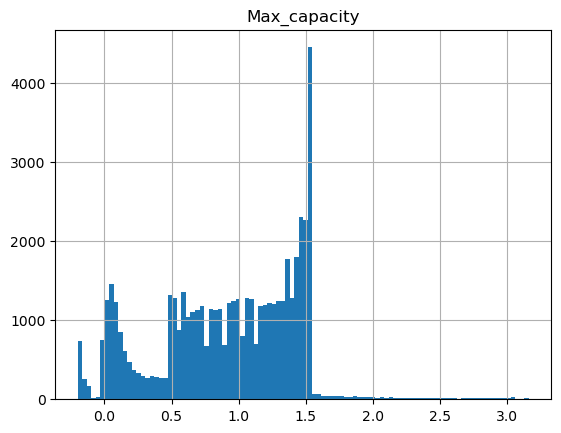

In [61]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a new DataFrame for the predicted values
predicted_df = merged_df.copy()

# Step 1: Split data into known_values and to_predict
known_values = merged_df.dropna(subset=['Max_capacity', 'Electricity_Cost_Frac'])
to_predict = merged_df[merged_df['Max_capacity'].isna()]

# Step 2: Create a regression model for Max_capacity
max_capacity_model = LinearRegression()
max_capacity_model.fit(known_values[['availability', 'area']], known_values['Max_capacity'])

# Step 3: Create a regression model for Electricity_Cost_Frac
electricity_cost_model = LinearRegression()
electricity_cost_model.fit(known_values[['availability', 'area']], known_values['Electricity_Cost_Frac'])

# Step 4: Predict missing values in to_predict and store in the predicted_df
predicted_df.loc[to_predict.index, 'Max_capacity'] = max_capacity_model.predict(to_predict[['availability', 'area']])
predicted_df.loc[to_predict.index, 'Electricity_Cost_Frac'] = electricity_cost_model.predict(to_predict[['availability', 'area']])

# Step 5: You can also replace NaN values in the original DataFrame (merged_df) if needed
# merged_df.update(to_predict)
predicted_df.hist('Max_capacity', bins=100)



In [62]:

# Calculate error metrics for Max_capacity predictions
max_capacity_predictions = max_capacity_model.predict(known_values[['availability', 'area']])
max_capacity_actual = known_values['Max_capacity']
mae_max_capacity = mean_absolute_error(max_capacity_actual, max_capacity_predictions)
mse_max_capacity = mean_squared_error(max_capacity_actual, max_capacity_predictions)
rmse_max_capacity = mse_max_capacity ** 0.5  # RMSE is the square root of MSE

# Calculate error metrics for Electricity_Cost_Frac predictions
electricity_cost_predictions = electricity_cost_model.predict(known_values[['availability', 'area']])
electricity_cost_actual = known_values['Electricity_Cost_Frac']
mae_electricity_cost = mean_absolute_error(electricity_cost_actual, electricity_cost_predictions)
mse_electricity_cost = mean_squared_error(electricity_cost_actual, electricity_cost_predictions)
rmse_electricity_cost = mse_electricity_cost ** 0.5  # RMSE is the square root of MSE

print("Max Capacity Prediction Metrics:")
print(f"MAE: {mae_max_capacity}")
print(f"MSE: {mse_max_capacity}")
print(f"RMSE: {rmse_max_capacity}")

print("\nElectricity Cost Fraction Prediction Metrics:")
print(f"MAE: {mae_electricity_cost}")
print(f"MSE: {mse_electricity_cost}")
print(f"RMSE: {rmse_electricity_cost}")

Max Capacity Prediction Metrics:
MAE: 0.3675408850573015
MSE: 0.3009846384427354
RMSE: 0.5486206689897268

Electricity Cost Fraction Prediction Metrics:
MAE: 0.03210852403878885
MSE: 0.0017018703651990135
RMSE: 0.041253731530602335


In [63]:
# Create a figure
fig = px.density_mapbox(predicted_df, 
                        lat='rounded_lat', 
                        lon='rounded_lon', 
                        z='Max_capacity', 
                        radius=5,
                        center=dict(lat=0, lon=0),
                        zoom=0.5,
                        mapbox_style="carto-positron",
                        labels={'Max_capacity': 'Max Capacity (GW)'})

# Update the layout
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(title='Availability'),
)

# Show the map
fig.show()

In [68]:
predicted_df.rename(columns={'rounded_lat':'Latitude', 'rounded_lon':'Longitude'}, inplace=True)
predicted_df.to_csv(os.path.join(data_dir, '20231029_land_max_capacity.csv'))
predicted_df

Latitude  Longitude  availability        area  Max_capacity  \
0         -75.0     -180.0           1.0  828.234558      0.480213   
1         -75.0     -179.0           1.0  828.234558      0.480213   
2         -75.0     -178.0           1.0  828.234558      0.480213   
3         -75.0     -177.0           1.0  828.234558      0.480213   
4         -75.0     -176.0           1.0  828.234558      0.480213   
...         ...        ...           ...         ...           ...   
54355      75.0      175.0           1.0  828.234558      0.480213   
54356      75.0      176.0           1.0  828.234558      0.480213   
54357      75.0      177.0           1.0  828.234558      0.480213   
54358      75.0      178.0           1.0  828.234558      0.480213   
54359      75.0      179.0           1.0  828.234558      0.480213   

       Electricity_Cost_Frac  
0                   0.441673  
1                   0.441673  
2                   0.441673  
3                   0.441673  
4                   0.441673  
...                      ...  
54355               0.441673  
54356               0.441673  
54357               0.441673  
54358               0.441673  
54359               0.441673  

[54360 rows x 6 columns]

In [2]:
lcoa_df = pd.read_csv(os.path.join('results','2050_lcoa_global_20231113_-180to180mp.csv'))
predicted_df = pd.read_csv(os.path.join(data_dir, '20231029_land_max_capacity.csv'))
lcoa_df

Unnamed: 0  Latitude  Longitude Country  Objective         Wind  \
0       -65_-180       -65       -180     NaN   0.305518  1222.779723   
1       -65_-179       -65       -179     NaN   0.305260  1211.734127   
2       -65_-178       -65       -178     NaN   0.303912  1200.710784   
3       -65_-177       -65       -177     NaN   0.302556  1190.418310   
4       -65_-176       -65       -176     NaN   0.302462  1199.636126   
...          ...       ...        ...     ...        ...          ...   
47155     65_175        65        175  Russia   0.654026  3010.818318   
47156     65_176        65        176  Russia   0.654026  3010.818318   
47157     65_177        65        177  Russia   0.654026  3010.818318   
47158     65_178        65        178  Russia   0.654026  3010.818318   
47159     65_179        65        179  Russia   0.654026  3010.818318   

             Solar  SolarTracking  Grid  RampDummy  ...          HB  \
0      1601.724382            0.0   0.0        0.0  ...  138.007080   
1      1651.620408            0.0   0.0        0.0  ...  138.619921   
2      1655.268369            0.0   0.0        0.0  ...  138.707179   
3      1673.297405            0.0   0.0        0.0  ...  138.444395   
4      1614.335330            0.0   0.0        0.0  ...  138.689487   
...            ...            ...   ...        ...  ...         ...   
47155     0.000000            0.0   0.0        0.0  ...  183.888249   
47156     0.000000            0.0   0.0        0.0  ...  183.888249   
47157     0.000000            0.0   0.0        0.0  ...  183.888249   
47158     0.000000            0.0   0.0        0.0  ...  183.888249   
47159     0.000000            0.0   0.0        0.0  ...  183.888249   

       BatteryInterfaceIn  BatteryInterfaceOut  HydrogenFuelCell  PenaltyLink  \
0                0.464510             0.459865         75.825392    1000000.0   
1                0.458407             0.453823         76.176925    1000000.0   
2                0.452884             0.448355         76.235424    1000000.0   
3                0.446879             0.442410         76.100337    1000000.0   
4                0.457621             0.453045         76.216998    1000000.0   
...                   ...                  ...               ...          ...   
47155            4.045035             4.004584        100.015998    1000000.0   
47156            4.045035             4.004584        100.015998    1000000.0   
47157            4.045035             4.004584        100.015998    1000000.0   
47158            4.045035             4.004584        100.015998    1000000.0   
47159            4.045035             4.004584        100.015998    1000000.0   

            Ammonia  CompressedH2Store    Battery  AccumulatedPenalty  \
0      15701.516324        4028.413653   1.839458          10000000.0   
1      15850.880460        3975.492088   1.815293          10000000.0   
2      15591.523584        3927.593814   1.793422          10000000.0   
3      14614.630222        3875.513588   1.769641          10000000.0   
4      14705.451569        3968.674999   1.812180          10000000.0   
...             ...                ...        ...                 ...   
47155  76597.848975       35080.157929  52.100045          10000000.0   
47156  76597.848975       35080.157929  52.100045          10000000.0   
47157  76597.848975       35080.157929  52.100045          10000000.0   
47158  76597.848975       35080.157929  52.100045          10000000.0   
47159  76597.848975       35080.157929  52.100045          10000000.0   

       Hydrogen Storage (t)  
0                102.244001  
1                100.900814  
2                 99.685122  
3                 98.363289  
4                100.727792  
...                     ...  
47155            890.359338  
47156            890.359338  
47157            890.359338  
47158            890.359338  
47159            890.359338  

[47160 rows x 23 columns]

In [3]:

lcoa_df = lcoa_df.merge(predicted_df[['Latitude', 'Longitude', 'availability', 'Max_capacity', 'Electricity_Cost_Frac']], on=['Latitude', 'Longitude'], how='left')
lcoa_df

Unnamed: 0  Latitude  Longitude Country  Objective         Wind  \
0       -65_-180       -65       -180     NaN   0.305518  1222.779723   
1       -65_-179       -65       -179     NaN   0.305260  1211.734127   
2       -65_-178       -65       -178     NaN   0.303912  1200.710784   
3       -65_-177       -65       -177     NaN   0.302556  1190.418310   
4       -65_-176       -65       -176     NaN   0.302462  1199.636126   
...          ...       ...        ...     ...        ...          ...   
47155     65_175        65        175  Russia   0.654026  3010.818318   
47156     65_176        65        176  Russia   0.654026  3010.818318   
47157     65_177        65        177  Russia   0.654026  3010.818318   
47158     65_178        65        178  Russia   0.654026  3010.818318   
47159     65_179        65        179  Russia   0.654026  3010.818318   

             Solar  SolarTracking  Grid  RampDummy  ...  HydrogenFuelCell  \
0      1601.724382            0.0   0.0        0.0  ...         75.825392   
1      1651.620408            0.0   0.0        0.0  ...         76.176925   
2      1655.268369            0.0   0.0        0.0  ...         76.235424   
3      1673.297405            0.0   0.0        0.0  ...         76.100337   
4      1614.335330            0.0   0.0        0.0  ...         76.216998   
...            ...            ...   ...        ...  ...               ...   
47155     0.000000            0.0   0.0        0.0  ...        100.015998   
47156     0.000000            0.0   0.0        0.0  ...        100.015998   
47157     0.000000            0.0   0.0        0.0  ...        100.015998   
47158     0.000000            0.0   0.0        0.0  ...        100.015998   
47159     0.000000            0.0   0.0        0.0  ...        100.015998   

       PenaltyLink       Ammonia  CompressedH2Store    Battery  \
0        1000000.0  15701.516324        4028.413653   1.839458   
1        1000000.0  15850.880460        3975.492088   1.815293   
2        1000000.0  15591.523584        3927.593814   1.793422   
3        1000000.0  14614.630222        3875.513588   1.769641   
4        1000000.0  14705.451569        3968.674999   1.812180   
...            ...           ...                ...        ...   
47155    1000000.0  76597.848975       35080.157929  52.100045   
47156    1000000.0  76597.848975       35080.157929  52.100045   
47157    1000000.0  76597.848975       35080.157929  52.100045   
47158    1000000.0  76597.848975       35080.157929  52.100045   
47159    1000000.0  76597.848975       35080.157929  52.100045   

       AccumulatedPenalty  Hydrogen Storage (t)  availability  Max_capacity  \
0              10000000.0            102.244001      1.000000      0.606584   
1              10000000.0            100.900814      1.000000      0.606584   
2              10000000.0             99.685122      1.000000      0.606584   
3              10000000.0             98.363289      1.000000      0.606584   
4              10000000.0            100.727792      1.000000      0.606584   
...                   ...                   ...           ...           ...   
47155          10000000.0            890.359338      0.498145      0.243021   
47156          10000000.0            890.359338      0.506255      0.222987   
47157          10000000.0            890.359338      0.502212      0.179599   
47158          10000000.0            890.359338      0.468815      0.166274   
47159          10000000.0            890.359338      0.398425      0.143399   

       Electricity_Cost_Frac  
0                   0.426443  
1                   0.426443  
2                   0.426443  
3                   0.426443  
4                   0.426443  
...                      ...  
47155               0.466270  
47156               0.469089  
47157               0.464479  
47158               0.436122  
47159               0.459030  

[47160 rows x 26 columns]

In [4]:
lcoa_df['LCOA'] = lcoa_df['Objective']
lcoa_df.to_csv(os.path.join('results', '2050_4.5_lcoa_global_max_capacity.csv'))


In [7]:
import plotly.express as px

# Create a figure
fig = px.density_mapbox(lcoa_df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='LCOA', 
                        radius=10,
                        center=dict(lat=0, lon=0),
                        zoom=0.5,
                        mapbox_style="carto-positron",
                        labels={'LCOA': 'LCOA (USD/t)'})

# Update the layout
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(title='LCOA'),
)

# Show the map
fig.show()